In [1]:
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import RLAgent

# Other utils functions
from reinforcetrader.utils.rewards import evaluate_reward_function

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

# Data Pre-processing and Feature Building

In [2]:
# Get DJI raw data using Yahoo Finance API
data_loader = RawDataLoader(start_date='1999-08-01', end_date='2025-08-11', index='DJI')

# Download or load from cache the data
raw_data = data_loader.get_hist_prices()

# Inspect the raw DJI close and volume data
display_df(raw_data)

Loading cached data from data/raw/DJI_tickers_data_1999-08-01_2025-08-11.csv


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT
Price,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-08-02,0.418405,27.008614,2.350000,26.759926,29.387829,15.095906,20.226343,17.283487,20.469776,43.912930,24.448803,34.258575,60.700550,23.529583,24.693939,14.641419,22.914881,18.153021,25.379461,25.952599,4.699342,0.038803,22.806913,6.088423,16.810499,6.075972,17.081629,9.014958,0.435292,27.437322,2.553125,27.930111,29.828847,15.192572,20.942139,17.532085,20.987403,45.136374,25.159241,34.557922,62.562533,23.785513,24.772832,14.915660,22.948382,18.356559,25.873867,26.602848,4.910285,0.038922,23.091604,6.158245,17.071633,6.217131,17.213026,9.254294,0.416529,26.279810,2.348438,26.708490,28.866626,15.047574,20.042281,17.224297,20.469776,43.607068,24.301816,34.158793,60.483320,23.417614,24.240295,14.626184,22.211354,17.733225,25.285289,25.818724,4.664185,0.038206,22.727833,6.032566,16.353515,5.990049,16.818835,8.935180,0.417467,26.279810,2.459375,27.158559,29.107181,15.112017,20.185441,17.295325,20.752118,44.917902,24.742777,34.358360,61.569475,23.529583,24.279744,14.763304,22.244855,17.898599,25.332374,26.220348,4.863409,0.038444,22.727833,6.032566,16.451440,5.990049,16.884533,9.001662,362443200,14186400,339356000,8751857,2641100,2118000,28405600,1705000,3526812,566400,4064100,1146355,4775095,3559800,6278850,5161000,2372700,2258287,3458295,48050600,14422400,313344000,4158800,581400,377100,3470400,3194070,16741800
1999-08-03,0.414653,26.279816,2.371875,26.065540,30.189682,14.918696,20.001381,17.614952,20.187431,42.514687,23.762867,33.826176,59.272991,24.105417,24.871447,14.824239,22.713873,18.343838,25.238214,25.933460,4.617310,0.037848,23.708441,6.046531,16.777863,5.627945,16.818838,8.921882,0.431070,27.158668,2.425000,27.055698,30.189682,15.192582,20.471761,17.626790,20.658002,43.912909,24.595791,34.491390,61.134972,24.313360,24.910893,14.900417,22.948382,18.394722,25.661990,26.335085,4.839972,0.038803,23.850786,6.102389,16.973713,5.891851,17.180180,9.121328,0.402457,25.786801,2.240625,25.924090,29.508109,14.805920,19.715063,17.259812,19.905089,42.470992,23.713870,33.593351,58.683365,23.817496,24.615039,14.656647,22.412361,18.178462,25.096957,25.818710,4.611450,0.037489,22.854368,5.990674,16.614654,5.609533,16.769565,8.788917,0.425910,27.072926,2.425000,26.901387,29.508109,15.095916,20.451310,17.567600,20.469773,43.912909,24.399809,34.258565,60.948772,24.025439,24.693934,14.656647,22.780875,18.292953,25.544274,26.277710,4.793095,0.038803,22.870184,6.060496,16.745221,5.891851,17.048783,9.054845,368379200,11616400,582780000,8694619,2854000,2275600,32937000,2072200,7458388,837700,585

In [3]:
# Instantiate Feature Builder to Build relevant features for state space
feature_builder = FeatureBuilder(hist_prices=raw_data)

# Build the features
feature_builder.build_features()
features_data = feature_builder.get_features()

# Inspect the features
display_df(features_data, rows=5)

Building ticker features: 100%|█████████████████████████████████████| 28/28 [00:08<00:00,  3.31it/s]


File already exists, skipping save: data/processed/DJI_tickers_features_2000-03-06_2025-08-08.csv


# State Representation

In [4]:
state_loader = EpisodeStateLoader(features_data, 'configs/regimes_trans_incl_episodes.json')

In [5]:
state_loader.get_state_matrix('train', 1, 'AAPL', 2, 4)

array([[-1.2905326e-01,  7.0966375e-01,  1.6128299e-01,  4.0364973e-02,
        -2.3643237e-01, -2.9205298e-01,  6.3006884e-01, -1.3275896e+00,
         9.7072423e-02,  1.1324788e-01, -6.9906610e-01],
       [-1.2905326e-01,  7.0966375e-01,  1.6128299e-01,  4.0364973e-02,
        -2.3643237e-01, -2.9205298e-01,  6.3006884e-01, -1.3275896e+00,
         9.7072423e-02,  1.1324788e-01, -6.9906610e-01],
       [ 8.1818557e-01,  1.1983429e-01,  6.1980117e-02,  1.6879718e+00,
         4.0972358e-01, -5.5037433e-04,  1.0632747e+00, -1.0059099e+00,
         2.7243415e-01,  1.2943491e-01,  9.8172224e-01],
       [ 8.9023381e-01,  1.4641949e-02,  9.5124215e-02,  2.2373035e+00,
         1.1739957e+00,  4.3950960e-01,  1.1950766e+00, -2.2343174e-01,
         3.7390298e-01,  1.5194972e-01,  1.1858761e+00]], dtype=float32)

In [6]:
state_loader.get_state_OHLCV('train', 1, 'AAPL', 1)

array([9.1983491e-01, 1.0263124e+00, 9.1279936e-01, 1.0127096e+00,
       5.2432800e+08], dtype=float32)

# Deep Q-Network and RL Agent

In [7]:
# Init the RL agent and DQN Model
agent_config = {
    'num_motif_features': 3,
    'num_context_features': 8,
    'learning_rate': 1e-3,
    'memory_buffer_len': 100000,
    'state_matrix_window': 60,
    'epsilon_start': 1.0,
    'epsilon_min': 0.05,
    'decay_updates': 50000,
    'discount_factor': 0.95
}

agent = RLAgent(agent_config=agent_config)

I0000 00:00:1756359288.481361 2637425 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Reward Function and Evaluation

[*********************100%***********************]  1 of 1 completed


Dropped 0 tickers. 1 tickers left.
Tickers dropped: 


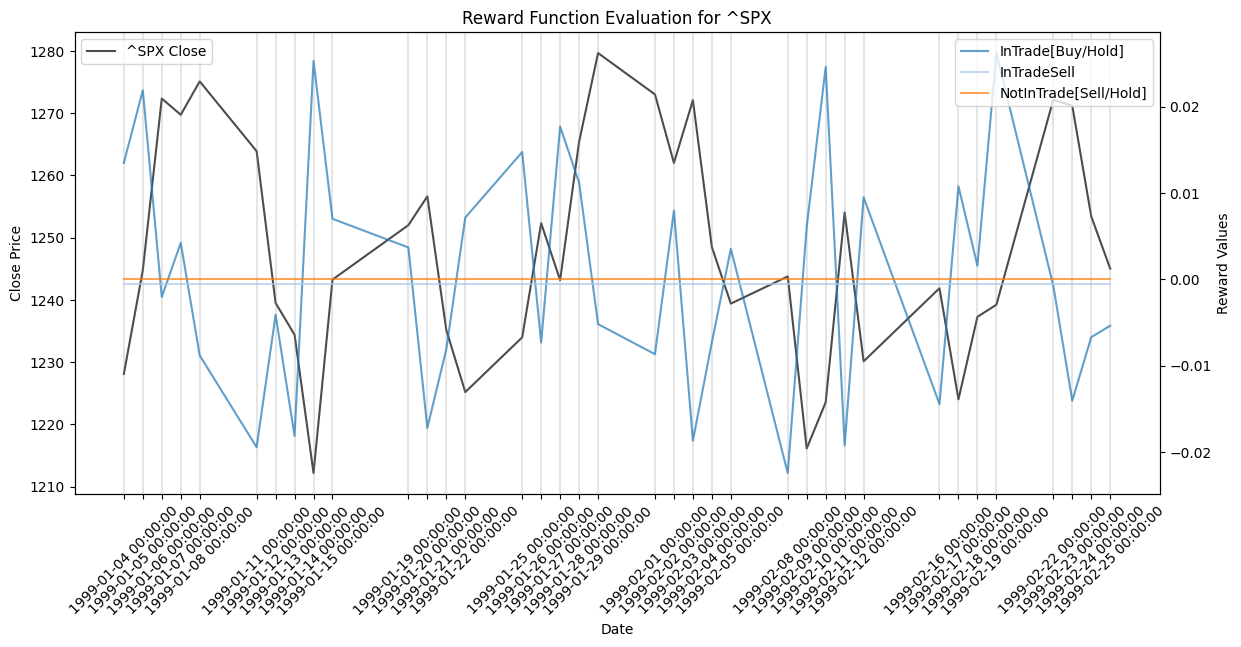

In [8]:
rewards = evaluate_reward_function(ticker='^SPX', start_date='1999-01-01', end_date='1999-03-01', reward_fn=agent.calculate_reward)

# Train Agent

In [9]:
training_config = {
    'batch_size': 256,
    'val_group_size': 5,
    'replay_start_size': 5000,
    'train_interval': 1,
    'gradient_step_repeat': 2,
    'model_dir': 'model_checkpoints/',
    'plots_dir': 'plots/',
    'logs_dir': 'logs/'
}

Training episode 1: 100%|████████████████████████████████████████| 28/28 [1:02:57<00:00, 134.91s/it]


Episode 1 summary: Train loss: 109.2486, Val loss: -0.5243, Total val trades: 121, Hit rate: 0.620


Training episode 2: 100%|████████████████████████████████████████| 28/28 [1:06:59<00:00, 143.54s/it]


Episode 2 summary: Train loss: 20.7542, Val loss: -0.2407, Total val trades: 44, Hit rate: 0.750


Training episode 3: 100%|████████████████████████████████████████| 28/28 [3:17:14<00:00, 422.66s/it]


Episode 3 summary: Train loss: 24.9436, Val loss: -1.6395, Total val trades: 327, Hit rate: 0.628


Training episode 4: 100%|████████████████████████████████████████| 28/28 [2:21:24<00:00, 303.01s/it]


Episode 4 summary: Train loss: 10.0229, Val loss: -0.0432, Total val trades: 240, Hit rate: 0.566


Training episode 5: 100%|████████████████████████████████████████| 28/28 [3:56:15<00:00, 506.28s/it]


Episode 5 summary: Train loss: 12.2098, Val loss: -1.0404, Total val trades: 310, Hit rate: 0.613


Training episode 6: 100%|████████████████████████████████████████| 28/28 [3:12:50<00:00, 413.22s/it]


Episode 6 summary: Train loss: 6.8403, Val loss: -0.9566, Total val trades: 187, Hit rate: 0.632


Training episode 7: 100%|████████████████████████████████████████| 28/28 [3:11:41<00:00, 410.76s/it]


Episode 7 summary: Train loss: 4.5322, Val loss: -0.3717, Total val trades: 85, Hit rate: 0.590


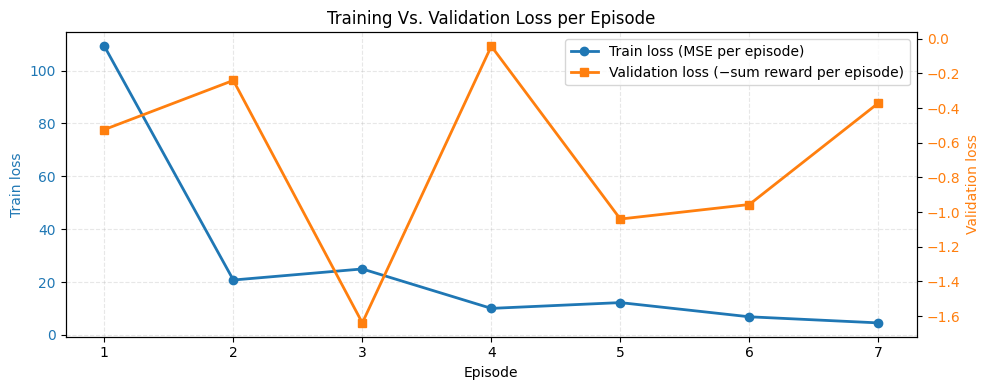

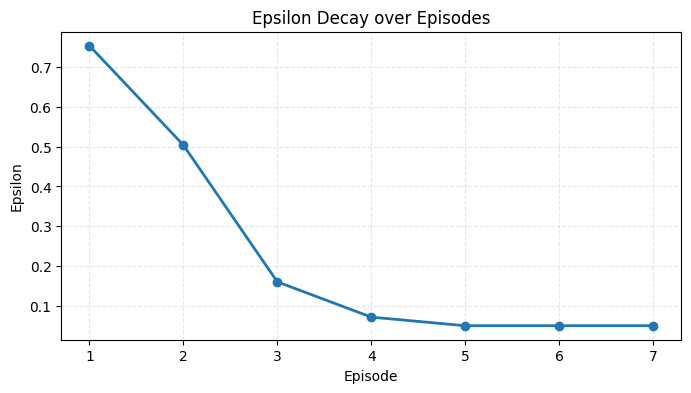

{1: {'train_loss': 109.24859953392297,
  'val_results': {'sum_reward': 0.5243165634938536,
   'total_trades': 121,
   'hit_rate': 0.6203703703703703},
  'epsilon': 0.7538081527393171},
 2: {'train_loss': 20.75417164398823,
  'val_results': {'sum_reward': 0.2406705436342313,
   'total_trades': 44,
   'hit_rate': 0.75},
  'epsilon': 0.5039673472293708},
 3: {'train_loss': 24.94357470443356,
  'val_results': {'sum_reward': 1.6394671179470697,
   'total_trades': 327,
   'hit_rate': 0.6277602523659306},
  'epsilon': 0.16024498472451484},
 4: {'train_loss': 10.022906072903425,
  'val_results': {'sum_reward': 0.04320305251777997,
   'total_trades': 240,
   'hit_rate': 0.5656108597285068},
  'epsilon': 0.07162548623324738},
 5: {'train_loss': 12.209767288848525,
  'val_results': {'sum_reward': 1.0404002780057056,
   'total_trades': 310,
   'hit_rate': 0.6127946127946128},
  'epsilon': 0.0499999999999733},
 6: {'train_loss': 6.840343824122101,
  'val_results': {'sum_reward': 0.9565996467828282,

In [10]:
episode_list = np.arange(1, 8)
agent.train(state_loader, episode_list, training_config)

# Test Agent Performance

In [12]:
test_config = {
    'plots_dir': 'plots/',
    'logs_dir': 'logs/',
    'outputs_dir': 'data/test/'
}
signals, prices = agent.test(state_loader, [1], test_config)

Testing episode 1: 100%|███████████████████████████████████████████| 28/28 [50:06<00:00, 107.38s/it]


In [1]:
# Temporary import for testing
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import RLAgent

# Other utils functions
from reinforcetrader.utils.portfolio_manager import PortfolioBackTester
from reinforcetrader.utils.rewards import evaluate_reward_function


# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

In [2]:
signals = pd.read_pickle('data/test/signals_20250828_231755.pkl')
prices = pd.read_pickle('data/test/prices_20250828_231755.pkl')

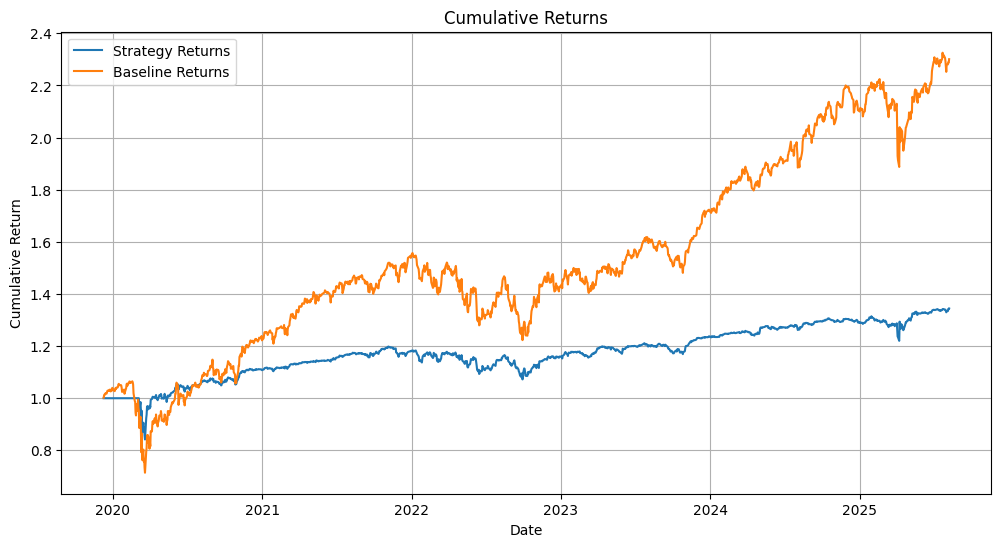

{'Total Return': np.float64(0.3444838570754605), 'Annualized Return': np.float64(0.05385777430899097), 'Max Drawdown': np.float64(-0.1582790669701487), 'Baseline Total Return': np.float32(1.3008728), 'Baseline Annualized Return': np.float32(0.15913188), 'Baseline Max Drawdown': np.float32(-0.3293425)}


In [3]:
pbt = PortfolioBackTester(signals, prices)
pbt.run_backtest()